# Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

account = pd.read_csv('data/account.csv',index_col=0)
card_dev = pd.read_csv('data/card_dev.csv', index_col=0)
client = pd.read_csv('data/client.csv', index_col=0)
disposition = pd.read_csv('data/disp.csv', index_col=0)
district = pd.read_csv('data/district.csv', index_col=0)
loan_dev = pd.read_csv('data/loan_dev.csv', index_col=0)
trans_dev = pd.read_csv('data/trans_dev.csv', index_col=0)

data = pd.read_csv('data_processed/data.csv', index_col=0)

/tmp/ipykernel_17515/16277762.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  trans_dev = pd.read_csv('data/trans_dev.csv', index_col=0)


In [2]:
print(f'''
account     shape: {account.shape}
client      shape: {client.shape}
disposition shape: {disposition.shape}
district    shape: {district.shape}
card        shape: {card_dev.shape}
loan        shape: {loan_dev.shape}
trans       shape: {trans_dev.shape}

data        shape:{data.shape}
''')


account     shape: (4500, 3)
client      shape: (5369, 2)
disposition shape: (5369, 3)
district    shape: (77, 15)
card        shape: (177, 3)
loan        shape: (328, 6)
trans       shape: (396685, 9)

data        shape:(328, 11)



/tmp/ipykernel_17515/179047535.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


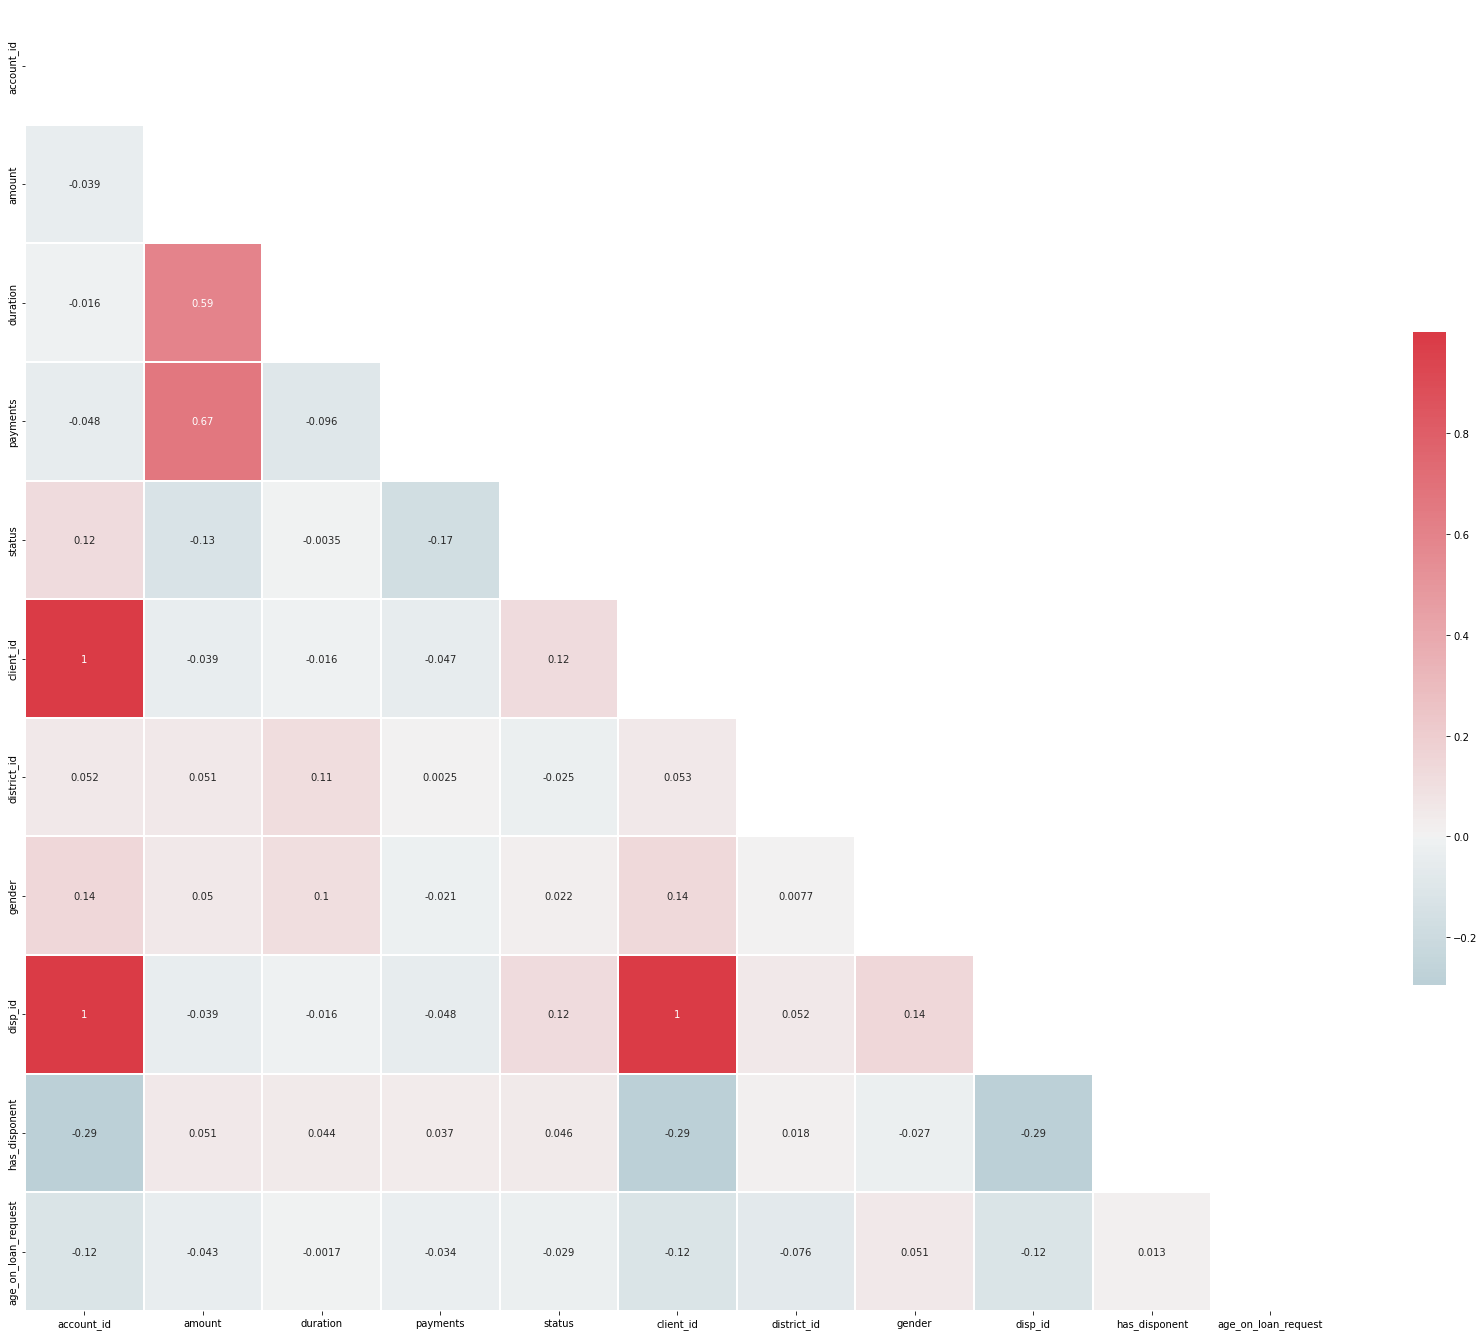

In [3]:
def get_correlation(df):

    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True


    plt.subplots(figsize=(30,24))

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,square=True, linewidths=.1, cbar_kws={"shrink": .5}, annot = True)

    y_lim = ax.get_ylim();
    ax.set_ylim(np.ceil(y_lim[0]), np.floor(y_lim[1]))
    

    plt.show()

get_correlation(data)
